# MPMS rock magnetic experiments data analysis

This notebook visualizes and analyzes data from low-temperature experiments conducted on an MPMS instrument and exported to MagIC format.

In the following example, specimens from samples of diabase dikes from the East Central Minnesota batholith have undergone the following experiments:
- **RTSIRM**: in this experiment, a pulsed field was applied at room temperature (300 K) with the specimen then being cycled down to 10 K (-263.15ºC) and back to room temperature.
- **FC LTSIRM**: in this experiment, the specimens were cooled down to 10 K in the presence of a strong field and then warmed back up to room temperature.
- **ZFC LTSIRM**: in this experiment, the specimens were cooled down in a zero-field environment, pulsed with a strong field at 10 K and then warmed back up to room temperature.

## Import scientific python libraries

In [ ]:
# If running in Google Colab, this code will install the necessary packages
# (otherwise skip this cell)
import requests

url = 'https://raw.githubusercontent.com/PmagPy/RockmagPy-notebooks/main/rockmag.py'
r = requests.get(url)

with open('rockmag.py', 'w') as f:
    f.write(r.text)

!pip install pmagpy
!pip install cartopy

In [1]:
import rockmag as rmag
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Download and import data

### Download and unpack data from MagIC

*At the moment, the ipmag.download_magic/ipmag.unpack_magic code is having a hard time with the IRM export file (see error below). This issue needs to be worked out. For the moment, we will manually unpack and work with the measurements file.*

In [2]:
# ipmag.download_magic('ECMB 2018.TXT', 
#                      dir_path = 'MPMS_data',
#                      input_dir_path = 'MPMS_data')

NameError: name 'ipmag' is not defined

### Import the measurements table

After unpacking the MagIC data, there is now a measurements table that we can import for analysis. 

In [2]:
# file = './MPMS_data/measurements.txt'
# Use this url for file if running in Google Colab
file = 'https://raw.githubusercontent.com/PmagPy/RockmagPy-notebooks/main/MPMS_data/measurements.txt'
measurements = pd.read_csv(file, sep='\t', skiprows=1)
measurements.head(1)

,Unnamed: 0,contribution_id,row_id,measurement,experiment,specimen,sequence,standard,quality,method_codes,instrument_codes,display_order,result_type,citations,treat_temp,treat_temp_decay_rate,treat_temp_dc_on,treat_temp_dc_off,treat_ac_field,treat_ac_field_decay_rate,treat_ac_field_dc_on,treat_ac_field_dc_off,treat_dc_field,treat_dc_field_decay_rate,treat_dc_field_ac_on,treat_dc_field_ac_off,treat_dc_field_theta,treat_dc_field_phi,treat_mw_power,treat_mw_time,treat_mw_integral,treat_mw_step,treat_step_num,meas_pos_x,meas_pos_y,meas_pos_z,meas_orient_theta,meas_orient_phi,meas_n_orient,meas_temp,meas_temp_change,meas_freq,meas_duration,meas_field_ac,meas_field_ac_theta,meas_field_ac_phi,meas_field_dc,meas_field_dc_theta,meas_field_dc_phi,inversion_height,inversion_residuals,magn_moment,magn_x,magn_x_sigma,magn_y,magn_y_sigma,magn_z,magn_z_sigma,magn_xyz_sigma,magn_induction,magn_b_x,magn_b_x_sigma,magn_b_y,magn_b_y_sigma,magn_b_z,magn_b_z_sigma,magn_b_111,magn_b_111_sigma,magn_b_xyz_sigma,magn_r2_det,dir_dec,dir_inc,dir_csd,magn_volume,magn_mass,magn_uncal,aniso_type,aniso_s,hyst_loop,hyst_sweep_rate,hyst_charging_mode,susc_chi_volume,susc_chi_mass,susc_chi_qdr_volume,susc_chi_qdr_mass,description,timestamp,software_packages,files,external_database_ids,derived_value,analysts
0,NaN,NaN,NaN,NED1-5c-IRM-VSM3-LP-HYS-218845-1,IRM-VSM3-LP-HYS-218845,NED1-5c,NaN,u,g,LP-HYS:LP-HYS-M,IRM-VSM3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.0,NaN,NaN,NaN,NaN,NaN,NaN,1.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020:01:06:10:14:00.00,NaN,NaN,NaN,NaN,NaN


### Get list of specimens and experiments

Now that we have imported the measurement pairs, we can look at the different experimental methods that have been applied to different specimens. The method codes correspond to the controlled vocabularies in the MagIC database.

| Method Code    | Definition |
| -------------- | ---------- |
| LP-BCR-BF      | Coercivity of remanence: Back field method | 
| LP-HYS:LP-HYS-M| Hysteresis loops |
| LP-CW-SIRM:LP-MC| Cycling between cooling and warming: Room temperature SIRM; Measured while cooling |
| LP-CW-SIRM:LP-MW| Cycling between cooling and warming: Room temperature SIRM; Measured while warming |
| LP-FC          | Field cooled: Remanent magnetization measured on warming |
| LP-ZFC         | Zero field cooled: Remanent magnetization measured on warming |


In [3]:
experiments = measurements.groupby(['specimen', 'method_codes']).size().reset_index().iloc[:, :2]
experiments

,specimen,method_codes
0,NED1-5c,LP-BCR-BF
1,NED1-5c,LP-HYS:LP-HYS-M
2,NED18-2c,LP-BCR-BF
3,NED18-2c,LP-CW-SIRM:LP-MC
4,NED18-2c,LP-CW-SIRM:LP-MW
5,NED18-2c,LP-FC
6,NED18-2c,LP-HYS:LP-HYS-M
7,NED18-2c,LP-ZFC
8,NED2-8c,LP-BCR-BF
9,NED2-8c,LP-CW-SIRM:LP-MC


### Extract MPMS data

We can now extract the MPMS data for a specific specimen.

First, we need to define the specimen for which we are extracting the data. To do this, we set `specimen_name` to be equal to a string (i.e. the specimen name within quotation marks).

Then, we can apply the `rmag.extract_mpms_data` function to extract the data for that specimen.

In [4]:
specimen_name = 'NED4-1c'

fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data = rmag.extract_mpms_data(measurements, specimen_name)

## Plot data

 We can now plot these data using the `rmag.plot_mpms_data()` function.

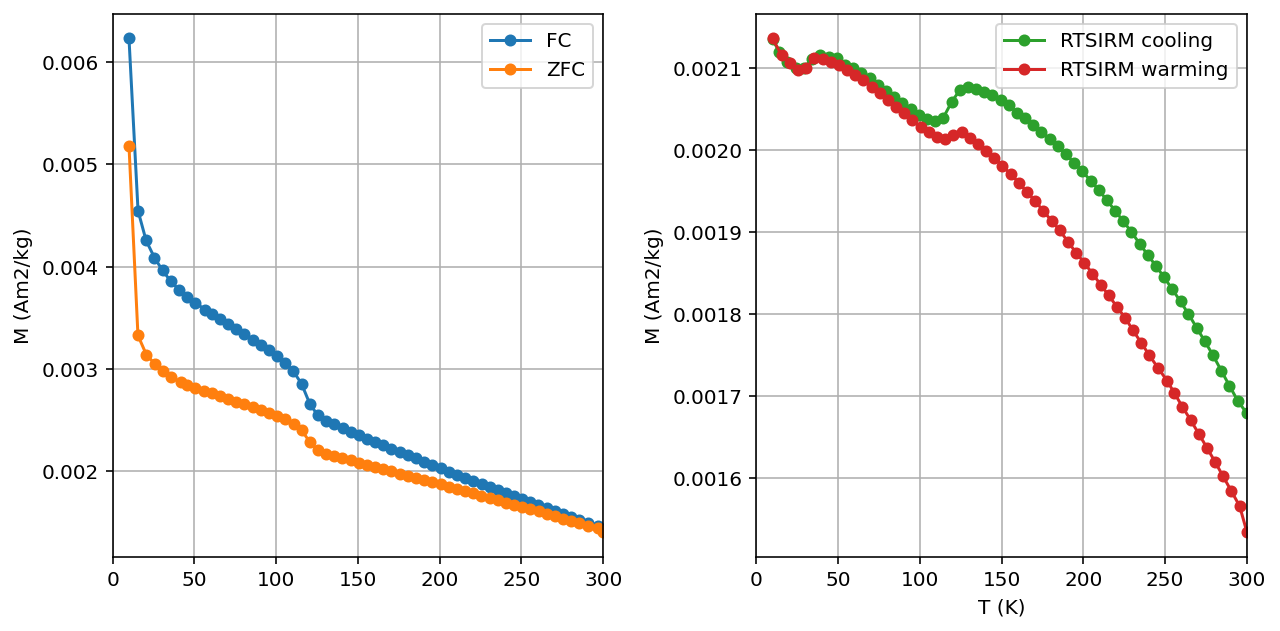

In [5]:
rmag.plot_mpms_data(fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data)

### Plot the derivative

By setting `plot_derivative=True`, the derivative of the experimental data will be calculated and plotted. 

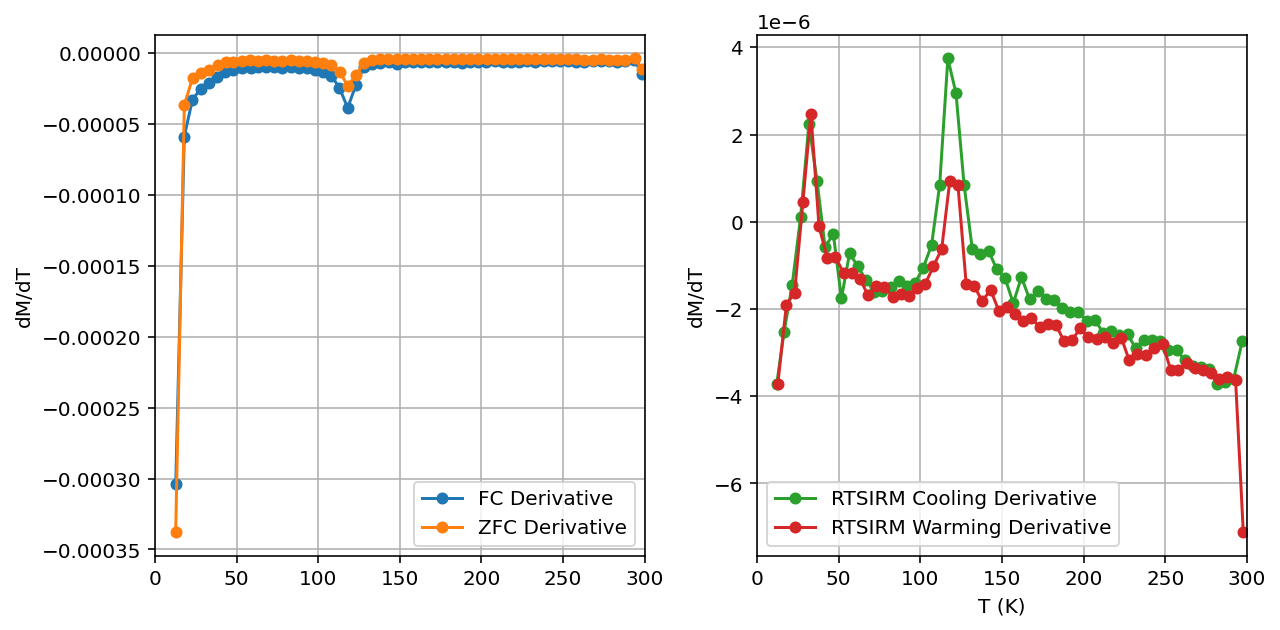

In [6]:
rmag.plot_mpms_data(fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data, plot_derivative=True)

### Make interactive plots

Rather than the static plots made above (which are made using matplotlib), you may want to make interactive plots. This can be done by putting in the parameter `use_plotly=True` which generates plots using Plotly.

In [7]:
rmag.plot_mpms_data(fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data, use_plotly=True)

In [8]:
rmag.plot_mpms_data(fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data, use_plotly=True, plot_derivative=True)

The colors and symbols of the plots can be customized by providing other values than the default parameters as in the example below:

In [9]:
rmag.plot_mpms_data(fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data, 
                   fc_color='orange', zfc_color='purple', rtsirm_cool_color='blue', rtsirm_warm_color='darkred',
                   fc_marker='^', zfc_marker='o', rtsirm_cool_marker='*', rtsirm_warm_marker='s',
                   symbol_size=5, use_plotly=True)

## Determine the Verwey transition temperature

### Background on the Verwey transition

For these mafic dikes from the East Central Minnesota batholith, the specimens exhibit a significant loss of remanence across the Verwey transition. The Verwey transition as defined by Jackson and Moskowitz (2020) is:

> The Verwey transition is a reorganization of the magnetite crystal structure occurring at a temperature T<sub>V</sub> in the range 80–125 K, where the room-temperature cubic inverse-spinel structure transforms to a monoclinic arrangement, and many physical properties of the mineral (e.g. electrical resistivity, heat capacity, magnetic susceptibility, remanence and coercivity) change significantly

It is of interest to determine the Verwey transition temperature (T<sub>V</sub>) as it is highly sensitive to changes in magnetite stoichiometry associated with cation substitution or oxidation.

### Estimating the Verwey transition temperature

It is preferable to estimate the temperature of the Verwey transition (T<sub>V</sub>) associated with warming curves (e.g. the FC/ZFC data) than cooling curves. The rationale is that cooling curves also pass through the isotropic point at a temperature of ∼130 K prior to going through the Verwey transition. The loss of magnetization associated with going through the isotropic point can be very large (particularly for multidomain magnetites) which can obscure the Verwey transition (Jackson and Moskowitz, 2020).

We can apply the method described in Jackson and Moskowitz (2020) to estimate the temperature of the Verwey transition. In this method, 

> [This approach] assumes that the loss of remanence on warming is due to the superposition of (1) progressive unblocking over the 20–300 K temperature range [e.g. due to the transition from the stable single-domain (SSD) to the superparamagnetic (SP) state in nanoparticle populations of magnetite or other magnetic phases] and (2) domain reorganization and intraparticle remanence rotation in a discrete temperature window around T<sub>V</sub>, due to the monoclinic-to-cubic transformation in magnetite.

The method to estimate the temperature of the Verwey transition of Jackson and Moskowitz (2020) is to fit the derivative of the data outside of the Verwey transition and then subtract that fit from the derivative. This approach seeks to isolate the signal that is due to the Verwey transition. The peak of the derivative curve can then be used to estimate T<sub>V</sub>. This is done as the interpolated zero crossing of the derivative of the spectrum curve.

In the code cell below, we define the temperature and magnetization values that will be used for estimating T<sub>V</sub>. The following parameters can be adjusted:

`t_range_background_min` and `t_range_background_max`: The temperature range over which the polynomial fit is applied to the background
`excluded_t_min` and `excluded_t_max`: The temperature range that is excluded from the background fit due to remanence loss associated with the Verwey transition.
`poly_deg`: the degree of the polynomial fit that is made to the background. Following Jackson and Moskowitz (2020), the default is set to be 3 (cubic).

As described in Jackson and Moskowitz (2020), these temperature ranges and polynomial degree can be adjusted to obtain ‘reasonable’ looking curves for the magnetite demagnetization and the progressive unblocking. The goal is for curves that are monotonic with and fits that are within the measurement noise, while seeking to minimizing the polynomial degree.

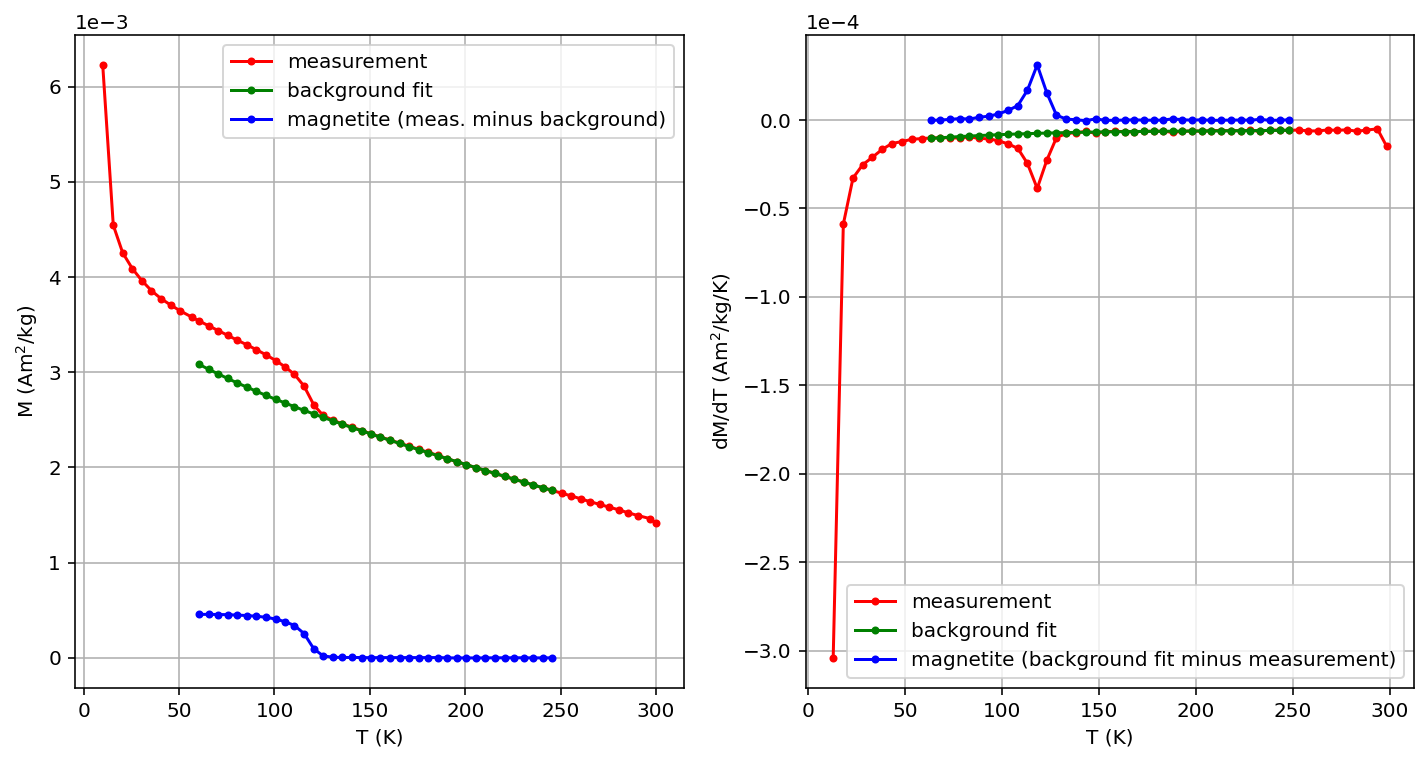

The T range for background fit is: 60 K to 250 K
The excluded T range is: 75 K to 150 K
The polynomial degree for background fit is: 3
The r-squared value for the background fit is: 0.975
The Verwey temperature estimate is: 117.9 K


In [10]:
temps = fc_data['meas_temp']
mags = fc_data['magn_mass']

#Enter the minimum temperature for the background fit
t_range_background_min = 60 

#Enter the maximum temperature for the background fit
t_range_background_max = 250 

#Enter the minimum temperature to exclude from the background fit
excluded_t_min = 75 

#Enter the maximum temperature to exclude from the background fit
excluded_t_max = 150 

#The polynomial degree for the background fit can be adjusted (default is 3)
poly_deg = 3

verwey_estimate = rmag.verwey_estimate(temps, mags, 
                                       t_range_background_min,
                                       t_range_background_max,
                                       excluded_t_min,
                                       excluded_t_max,
                                       poly_deg)

## Plot the second derivative curve

The estimate of the Verwey transition calculated above uses second derivative and calculates where the second derivative crosses zero by interpolating from the points on either side of the peak in the first derivative. This calculation can be visualized by setting the parameter `plot_zero_crossing = True` which generates an additional plot.

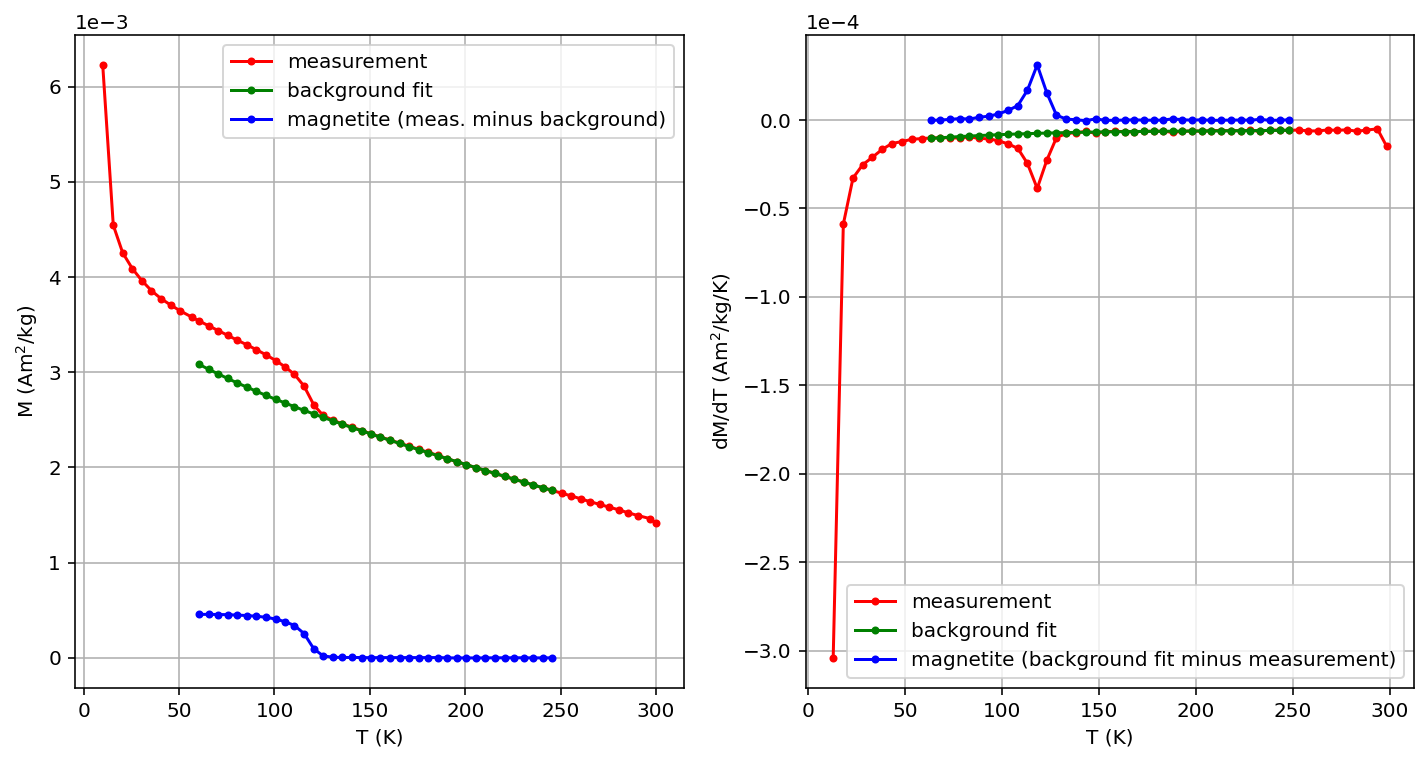

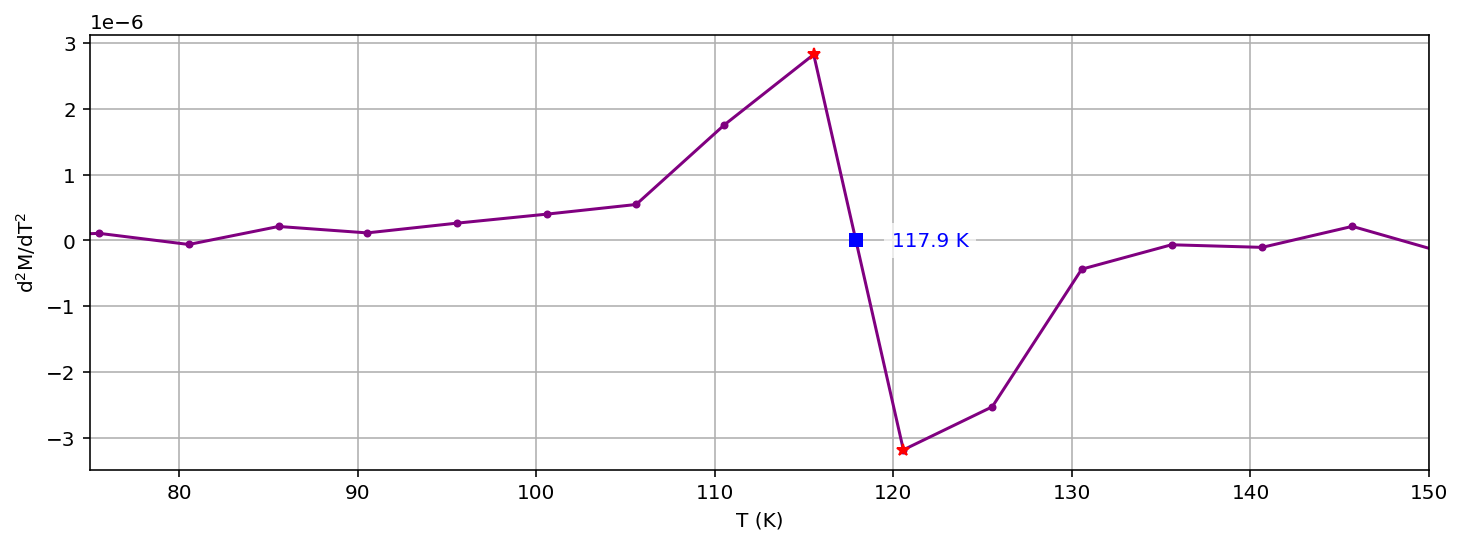

The T range for background fit is: 60 K to 250 K
The excluded T range is: 75 K to 150 K
The polynomial degree for background fit is: 3
The r-squared value for the background fit is: 0.975
The Verwey temperature estimate is: 117.9 K


In [11]:
verwey_estimate = rmag.verwey_estimate(temps, mags, 
                                       t_range_background_min,
                                       t_range_background_max,
                                       excluded_t_min,
                                       excluded_t_max,
                                       poly_deg,
                                       plot_zero_crossing = True)

## Determine the Verwey temperatures for additional specimens

There are three more specimens with LT-SIRM data. Let's plot those data and determine Verwey temperature estimates.

NED18-2c


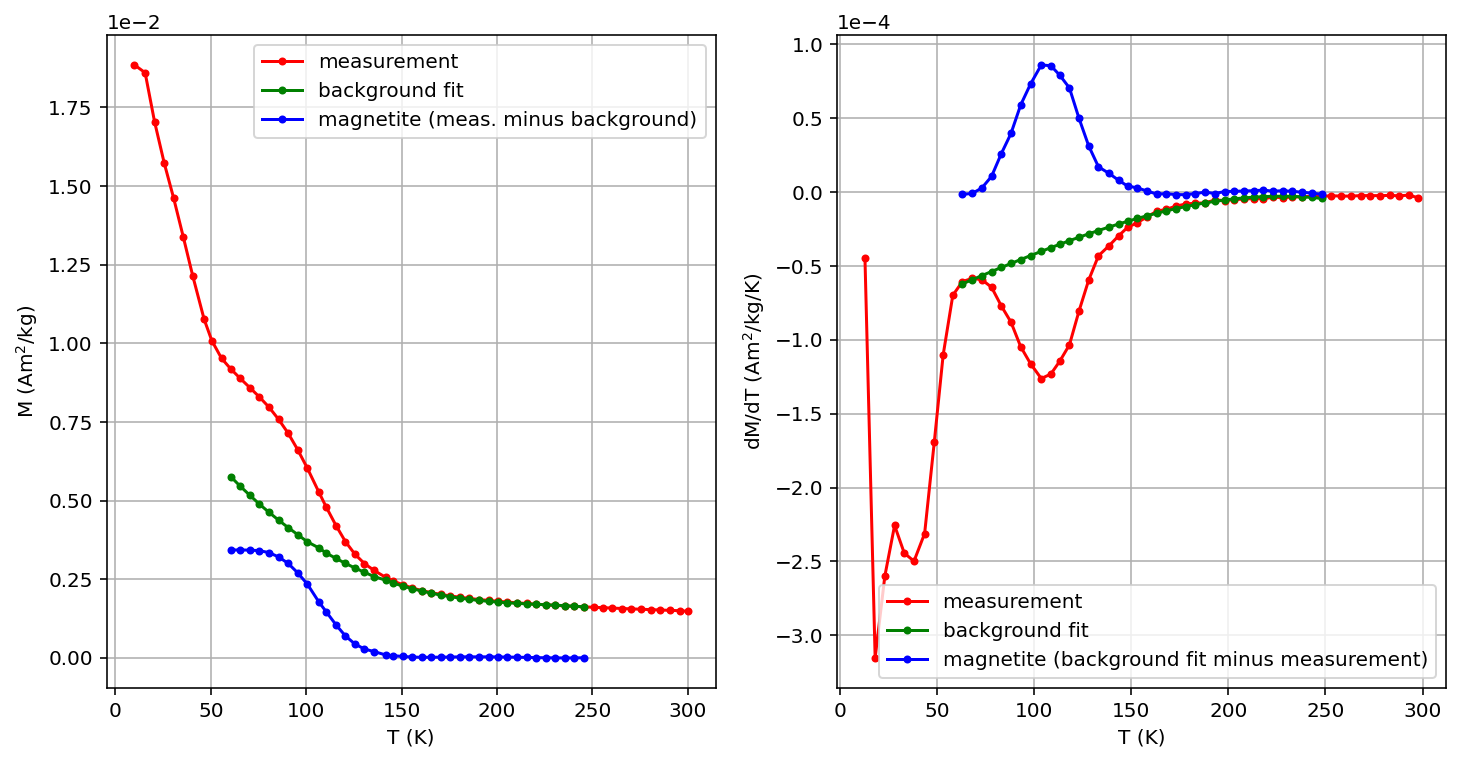

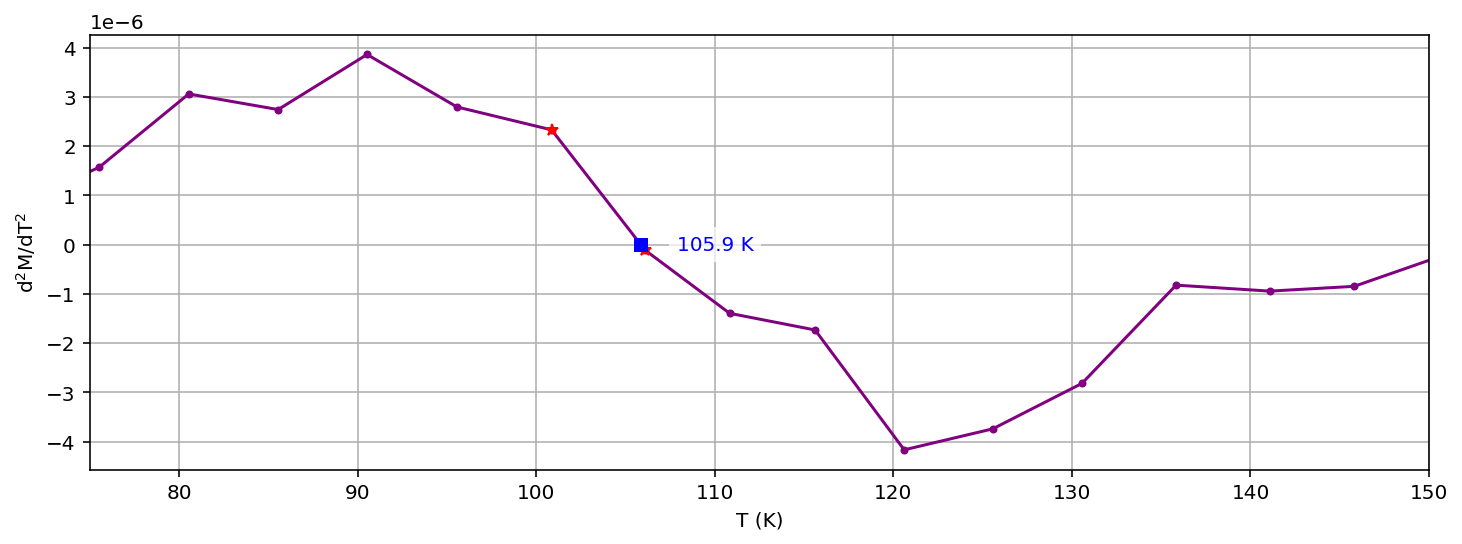

The T range for background fit is: 60 K to 250 K
The excluded T range is: 75 K to 150 K
The polynomial degree for background fit is: 3
The r-squared value for the background fit is: 0.995
The Verwey temperature estimate is: 105.9 K

NED2-8c


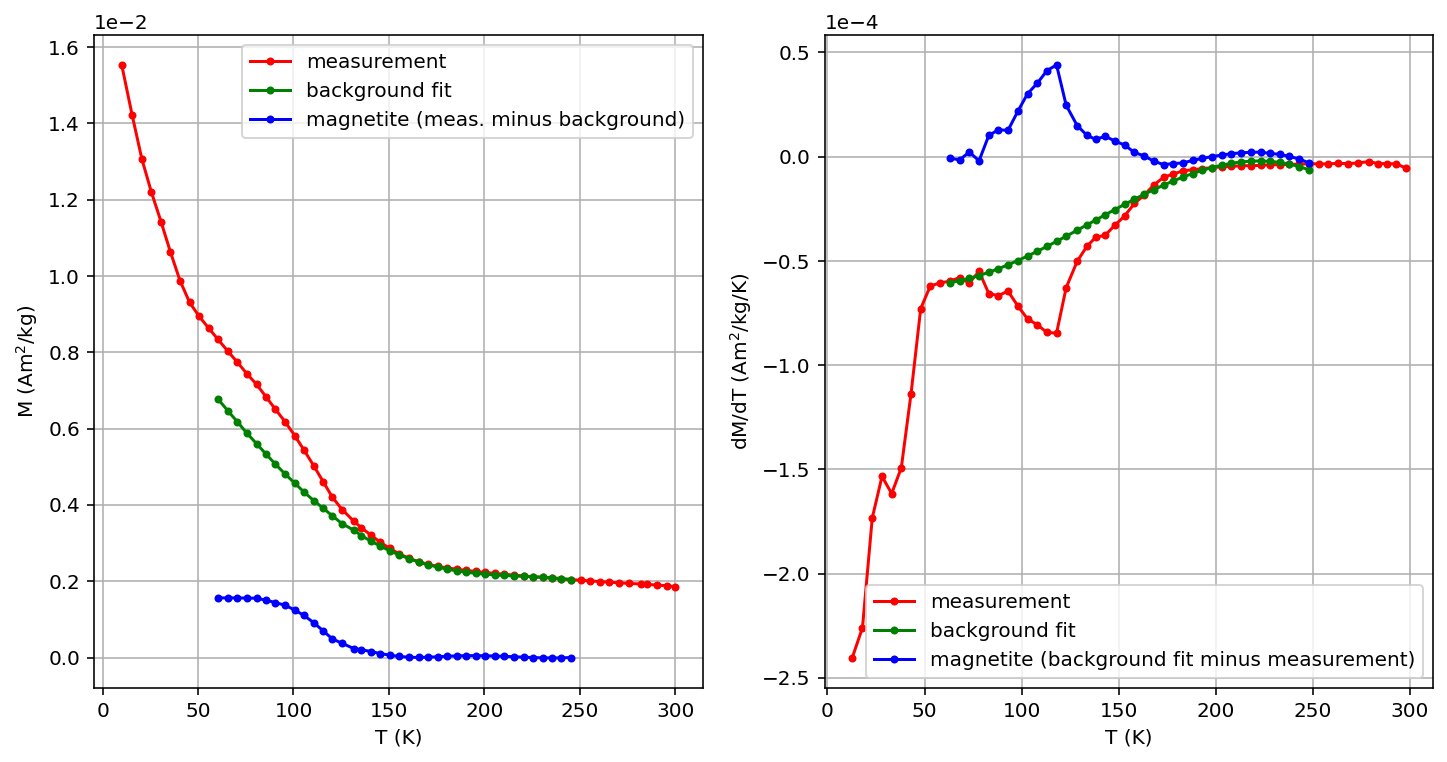

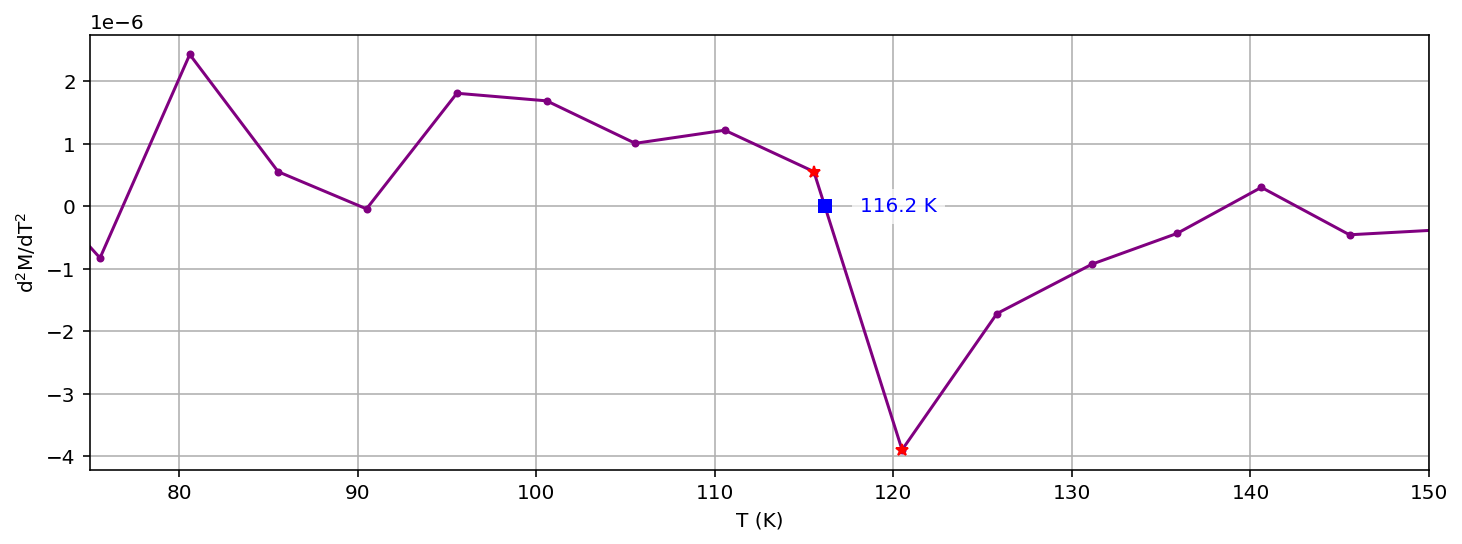

The T range for background fit is: 60 K to 250 K
The excluded T range is: 75 K to 150 K
The polynomial degree for background fit is: 3
The r-squared value for the background fit is: 0.985
The Verwey temperature estimate is: 116.2 K

NED2-8c


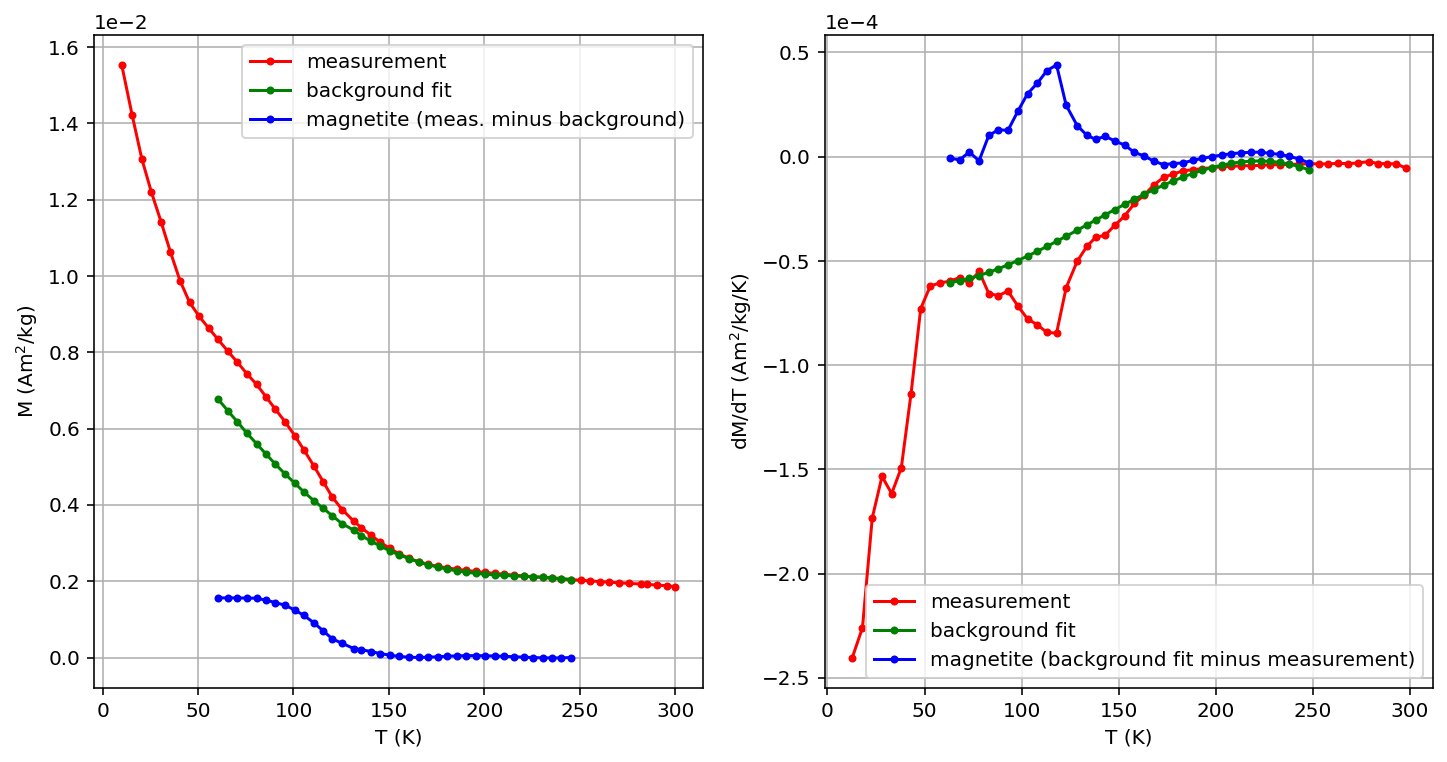

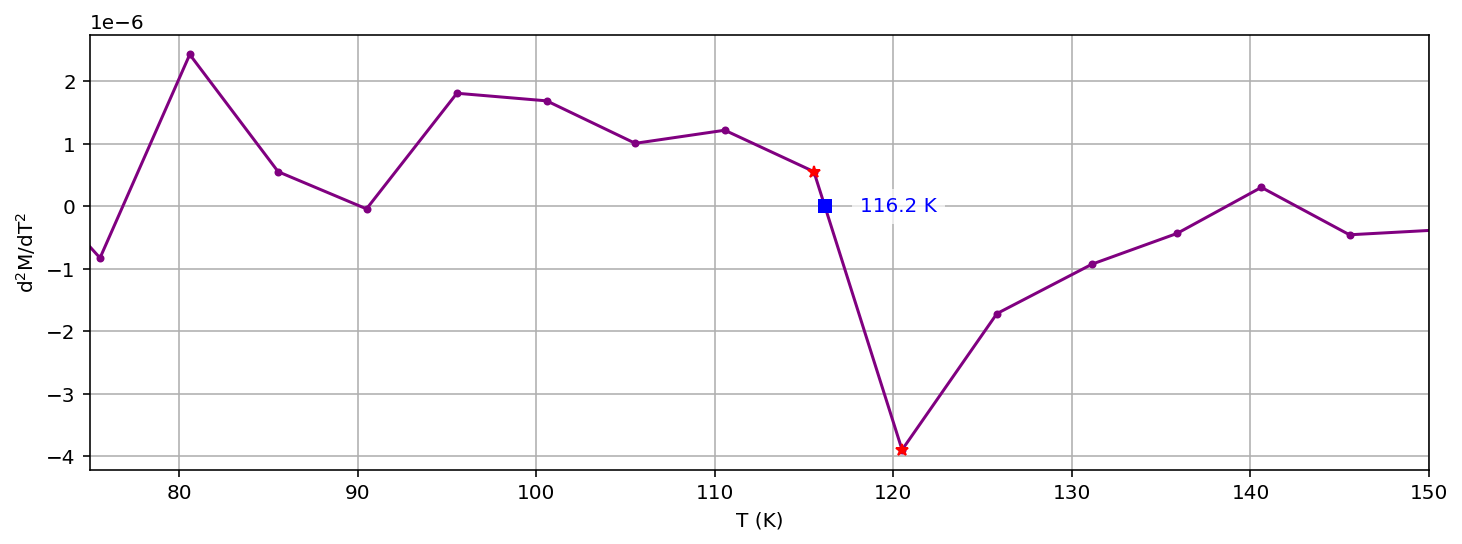

The T range for background fit is: 60 K to 250 K
The excluded T range is: 75 K to 150 K
The polynomial degree for background fit is: 3
The r-squared value for the background fit is: 0.985
The Verwey temperature estimate is: 116.2 K


In [12]:
specimen_name = 'NED18-2c'
print(specimen_name)
fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data = rmag.extract_mpms_data(measurements, specimen_name)
temps = fc_data['meas_temp']
mags = fc_data['magn_mass']
verwey_estimate = rmag.verwey_estimate(temps, mags, 
                                       t_range_background_min=60,
                                       t_range_background_max=250,
                                       excluded_t_min=75,
                                       excluded_t_max=150,
                                       poly_deg=3,
                                       plot_zero_crossing = True)

print('')

specimen_name = 'NED2-8c'
print(specimen_name)
fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data = rmag.extract_mpms_data(measurements, specimen_name)
temps = fc_data['meas_temp']
mags = fc_data['magn_mass']
verwey_estimate = rmag.verwey_estimate(temps, mags, 
                                       t_range_background_min=60,
                                       t_range_background_max=250,
                                       excluded_t_min=75,
                                       excluded_t_max=150,
                                       poly_deg=3,
                                       plot_zero_crossing = True)

print('')

specimen_name = 'NED2-8c'
print(specimen_name)
fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data = rmag.extract_mpms_data(measurements, specimen_name)
temps = fc_data['meas_temp']
mags = fc_data['magn_mass']
verwey_estimate = rmag.verwey_estimate(temps, mags, 
                                       t_range_background_min=60,
                                       t_range_background_max=250,
                                       excluded_t_min=75,
                                       excluded_t_max=150,
                                       poly_deg=3,
                                       plot_zero_crossing = True)